# Project - Voice - to - text Classification of Maritime Incidents 

Machine Learning and Content Analytics - PT

Authors: Eleni- Theodora Lyssea (p2822418) & Natalia Tsamtsouri (p2822435)

Initial cleaning and reshaping of maritime incident dataset for classification tasks

In [1]:
# Dataset Preprocess

import pandas as pd

# We load the dataset
df = pd.read_csv('occurrences.csv', sep=';', low_memory=False)

# We rename the 'Description' column to 'report'
df = df.rename(columns={'Description': 'report'})

# WE use the 'Main_Event_L1' column as the incident category
df['category'] = df['Main_Event_L1']

# We map the severity levels to 4 classes: Low, Medium, High, Critical
severity_map = {
    'Less Serious': 'Low',
    'Serious': 'Medium',
    'Very Serious': 'High',
    'Marine Incident': 'Critical'
}
df['severity'] = df['Occurrence_Severity'].map(severity_map)

Descriptive analysis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4354 entries, 0 to 4353
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Occurrence_Id                  4354 non-null   object 
 1   Local_Date_Main_Event          4354 non-null   object 
 2   Date_Main_Event_Unconfirmed    4354 non-null   object 
 3   Year_Reported                  4354 non-null   int64  
 4   Occurrence_Severity            4354 non-null   object 
 5   Main_Event_L1                  4353 non-null   object 
 6   Main_Event_L2                  1884 non-null   object 
 7   Main_Event_L3                  131 non-null    object 
 8   Not_Vessel_Operations          4354 non-null   bool   
 9   Short_Description              4354 non-null   object 
 10  report                         4354 non-null   object 
 11  National_Keywords              64 non-null     object 
 12  EMCIP_Keywords                 65 non-null     o

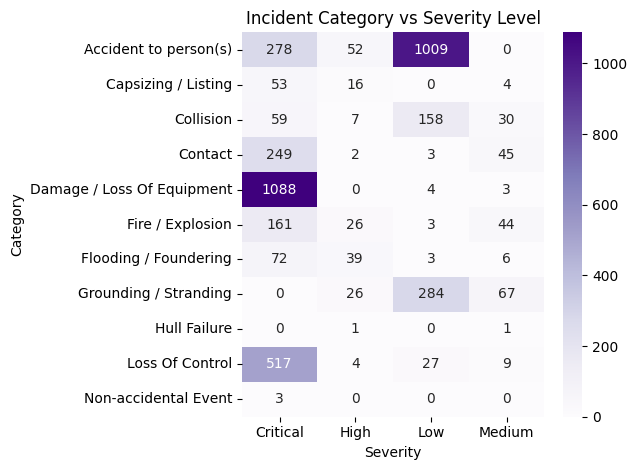

In [2]:
df.shape  # 4354 rows , 39 cols
df.columns  
df.info()  

# Category distribution
df['category'].value_counts()
df['category'].value_counts(normalize=True) * 100
# Severity distribution
df['severity'].value_counts()
df['severity'].value_counts(normalize=True) * 100

# Category * Severity cross table
pd.crosstab(df['category'], df['severity'])
# Visualization of Category * Severity matrix as a heatmap
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(pd.crosstab(df['category'], df['severity']), annot=True, fmt='d', cmap='Purples')
plt.title("Incident Category vs Severity Level")
plt.ylabel("Category")
plt.xlabel("Severity")
plt.tight_layout()
plt.show()

In [3]:

# We keep only the 3 columns we need for classification and save to new CSV
df[['report', 'category', 'severity']].to_csv('incidents_categorized.csv', index=False)

In [4]:
# We check unique values
print(df["category"].value_counts())
print(df["severity"].value_counts())

category
Accident to person(s)         1339
Damage / Loss Of Equipment    1095
Loss Of Control                557
Grounding / Stranding          377
Contact                        299
Collision                      254
Fire / Explosion               234
Flooding / Foundering          120
Capsizing / Listing             73
Non-accidental Event             3
Hull Failure                     2
Name: count, dtype: int64
severity
Critical    2480
Low         1491
Medium       209
High         174
Name: count, dtype: int64


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv('incidents_categorized.csv')
df = df.dropna(subset=['category'])
print(f"Remaining rows: {len(df)}")


Remaining rows: 4353


In [6]:
# Checking NaN
print("Missing in category:", df['category'].isna().sum())
print("Missing in severity:", df['severity'].isna().sum())

Missing in category: 0
Missing in severity: 0


# Merge rare labels:

In [7]:
import pandas as pd

# 1) Hull Failure ---> Damage / Loss Of Equipment
df['category'] = df['category'].replace(
    {'Hull Failure': 'Damage / Loss Of Equipment'}
)

# 2) Non‑accidental Event --->  Accident to person(s)
df['category'] = df['category'].replace(
    {'Non-accidental Event': 'Accident to person(s)'}
)

# Checking new distribution
print(df['category'].value_counts())

category
Accident to person(s)         1342
Damage / Loss Of Equipment    1097
Loss Of Control                557
Grounding / Stranding          377
Contact                        299
Collision                      254
Fire / Explosion               234
Flooding / Foundering          120
Capsizing / Listing             73
Name: count, dtype: int64


# Clean placeholder texts and split:

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

#We remove placeholder reports that do not provide information
mask = df['report'].str.strip() != "See MAIB investigation report, when available"
df = df[mask]

print("Rows after dropping placeholders:", len(df))

Rows after dropping placeholders: 4311


In [9]:

# Stratified split into train/val/test sets based on category
train, temp = train_test_split(df, test_size=0.30, stratify=df['category'], random_state=42)
val, test  = train_test_split(temp, test_size=0.50, stratify=temp['category'], random_state=42)

# Save splits
train.to_csv('train.csv', index=False)
val.  to_csv('val.csv',   index=False)
test. to_csv('test.csv',  index=False)

print(f"Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")


Train: 3017, Val: 647, Test: 647


# DATA AUGMENTATION

Extraction of the minority samples

In [10]:
train = pd.read_csv("train.csv")
# We find categories with <150 samples to balance
counts = train['category'].value_counts()
small_cats = counts[counts < 150].index.tolist()
minority_df = train[train['category'].isin(small_cats)]

AUGMENTATION IN MERGED CLASSES - METHODS: Back translation, Contextual substitution 

In [11]:
# pip install sentencepiece --required library
from transformers import MarianMTModel, MarianTokenizer
import nlpaug.augmenter.word as naw

# Back-translation function (via French)
# It translates text to French and back to English
def back_translate(text, src="en", mid="fr"):
    tok_fwd = MarianTokenizer.from_pretrained(f'Helsinki-NLP/opus-mt-{src}-{mid}')
    mdl_fwd = MarianMTModel.from_pretrained(f'Helsinki-NLP/opus-mt-{src}-{mid}')
    fr = mdl_fwd.generate(**tok_fwd(text, return_tensors="pt", truncation=True))
    fr_text = tok_fwd.decode(fr[0], skip_special_tokens=True)
    tok_rev = MarianTokenizer.from_pretrained(f'Helsinki-NLP/opus-mt-{mid}-{src}')
    mdl_rev = MarianMTModel.from_pretrained(f'Helsinki-NLP/opus-mt-{mid}-{src}')
    en = mdl_rev.generate(**tok_rev(fr_text, return_tensors="pt", truncation=True))
    return tok_rev.decode(en[0], skip_special_tokens=True)

# Contextual substitution augmenter using DistilBERT
aug_ctx = naw.ContextualWordEmbsAug(
    model_path="distilbert-base-cased",
    action="substitute"
)
# We apply augmentation 4× per minority sample
augmented = []
for _, row in minority_df.iterrows():
    txt = row['report']
    cat = row['category']
    sev = row['severity']

    augmented += [
        {"report": back_translate(txt, mid="fr"), "category": cat, "severity": sev},
        {"report": back_translate(txt, mid="de"), "category": cat, "severity": sev},
        {"report": aug_ctx.augment(txt),                "category": cat, "severity": sev},
        {"report": aug_ctx.augment(txt),                "category": cat, "severity": sev},
    ]

aug_df = pd.DataFrame(augmented)

c:\Users\elena\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\elena\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Merge with original train set

In [12]:
balanced_train = pd.concat([train, aug_df], ignore_index=True)
balanced_train = balanced_train.sample(frac=1, random_state=42)
balanced_train.to_csv("train_augmented.csv", index=False)

# Predictions on test set

In [13]:
import pandas as pd
from run_pipeline import predict_category, predict_severity
from tqdm import tqdm  # Progress bar

# Load test set
df = pd.read_csv("test.csv") 

texts = df["report"].tolist()
true_categories = df["category"].tolist()
true_severities = df["severity"].tolist()

# Predict with pipeline
pred_categories = []
pred_severities = []

for text in texts:
    pred_cat, _, _ = predict_category(text)
    pred_sev, _, _ = predict_severity(text)
    pred_categories.append(pred_cat)
    pred_severities.append(pred_sev)

# Creation of the  output dataframe
df_out = pd.DataFrame({
    "report": texts,
    "true_category": true_categories,
    "pred_category": pred_categories,
    "true_severity": true_severities,
    "pred_severity": pred_severities
})

# Save to CSV
df_out.to_csv("predictions.csv", index=False)
print("predictions.csv created successfully.")

Device set to use cpu
Using `chunk_length_s` is very experimental with seq2seq models. The results will not necessarily be entirely accurate and will have caveats. More information: https://github.com/huggingface/transformers/pull/20104. Ignore this warning with pipeline(..., ignore_warning=True). To use Whisper for long-form transcription, use rather the model's `generate` method directly as the model relies on it's own chunking mechanism (cf. Whisper original paper, section 3.8. Long-form Transcription).
Generating validation split: 647 examples [00:00, 9783.52 examples/s]


predictions.csv created successfully.


 Category Evaluation
                            precision    recall  f1-score   support

     Accident to person(s)      0.960     0.970     0.965       199
       Capsizing / Listing      0.769     1.000     0.870        10
                 Collision      0.900     0.947     0.923        38
                   Contact      0.825     0.750     0.786        44
Damage / Loss Of Equipment      0.938     0.909     0.923       165
          Fire / Explosion      0.872     0.971     0.919        35
     Flooding / Foundering      1.000     0.824     0.903        17
     Grounding / Stranding      0.926     0.893     0.909        56
           Loss Of Control      0.826     0.855     0.840        83

                  accuracy                          0.913       647
                 macro avg      0.891     0.902     0.893       647
              weighted avg      0.915     0.913     0.913       647

Accuracy: 0.913
F1 weighted: 0.913


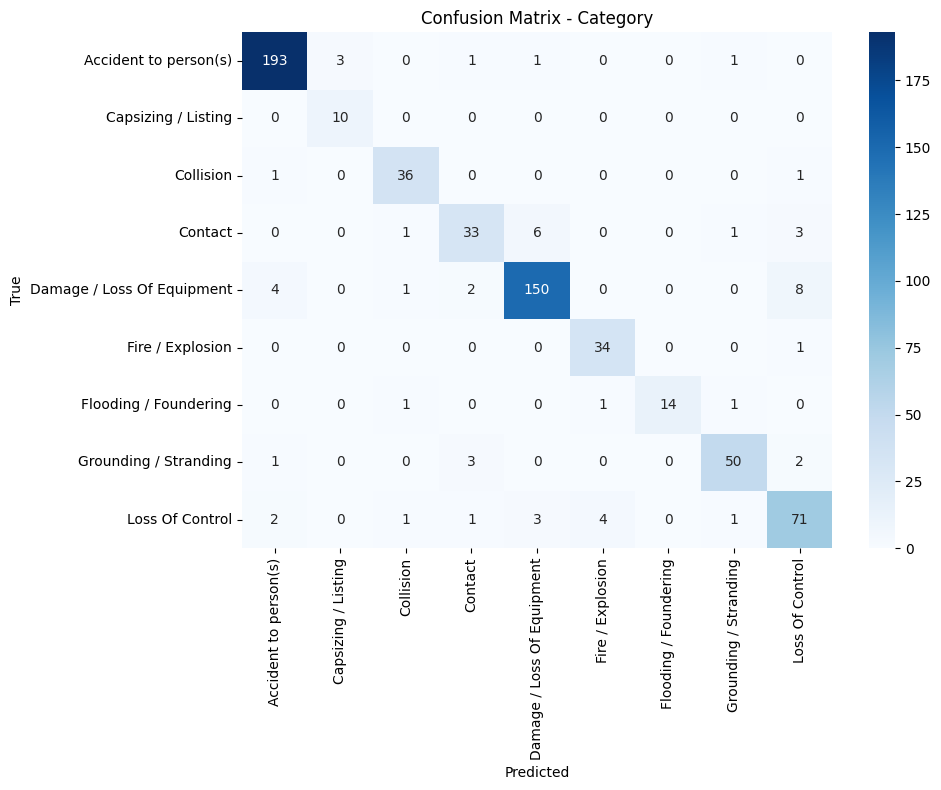


 Severity Evaluation
              precision    recall  f1-score   support

    Critical      0.868     0.903     0.885       371
        High      0.647     0.611     0.629        18
         Low      0.813     0.824     0.819       222
      Medium      0.316     0.167     0.218        36

    accuracy                          0.827       647
   macro avg      0.661     0.626     0.638       647
weighted avg      0.812     0.827     0.818       647

Accuracy: 0.827
F1 weighted: 0.818


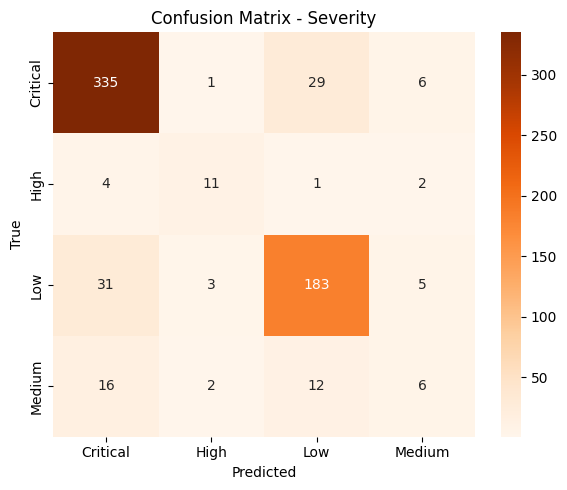

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

# 1 Confusion Matrix – Category
cat_labels = sorted(df_out["true_category"].unique())
cm_cat = confusion_matrix(df_out["true_category"], df_out["pred_category"], labels=cat_labels)

print(" Category Evaluation")
print(classification_report(df_out["true_category"], df_out["pred_category"], digits=3))
print(f"Accuracy: {accuracy_score(df_out['true_category'], df_out['pred_category']):.3f}")
print(f"F1 weighted: {f1_score(df_out['true_category'], df_out['pred_category'], average='weighted'):.3f}")

plt.figure(figsize=(10, 8))
sns.heatmap(cm_cat, annot=True, fmt="d", cmap="Blues", xticklabels=cat_labels, yticklabels=cat_labels)
plt.title("Confusion Matrix - Category")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("confusion_matrix_category.png")
plt.show()

# 2 Confusion Matrix – Severity
sev_labels = sorted(df_out["true_severity"].unique())
cm_sev = confusion_matrix(df_out["true_severity"], df_out["pred_severity"], labels=sev_labels)

print("\n Severity Evaluation")
print(classification_report(df_out["true_severity"], df_out["pred_severity"], digits=3))
print(f"Accuracy: {accuracy_score(df_out['true_severity'], df_out['pred_severity']):.3f}")
print(f"F1 weighted: {f1_score(df_out['true_severity'], df_out['pred_severity'], average='weighted'):.3f}")

plt.figure(figsize=(6, 5))
sns.heatmap(cm_sev, annot=True, fmt="d", cmap="Oranges", xticklabels=sev_labels, yticklabels=sev_labels)
plt.title("Confusion Matrix - Severity")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("confusion_matrix_severity.png")
plt.show()
